# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Описание данных
Признаки для обучения
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

# План исследования: 
1. Загрузка данных, изучение и подготовка данных для обучения.
2. Подготовка выборок для обучения моделей.
3. Обучение моделей, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
4. Анализ время обучения, время предсказания и качества моделей. Выбор лучшей в соответствии с критериями заказчика.

## Подготовка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
#from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

In [2]:
try:
    data = pd.read_csv('/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [3]:
data.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
nans = data.isna().sum().to_frame().rename(
    columns = {0:'nans_count'}).query('nans_count > 0').sort_values(by='nans_count', ascending=False)
nans['nans_percent'] = nans['nans_count']*100/len(data)
nans

,nans_count,nans_percent
Repaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588


Вывод: пропусков очень много: 20% в колонке Repaired, 10,5% в типе кузова, 9.3% в типе топлива, по 5,6% в типе коробки передач и модели автомобиля. Можно предположить, что пропуски в данных Repaired не были заполнены по причине отсутсвия ремонта или наоборот, собственник не хочет указывать факт ремонта,  эти пропуски можно заполунить значнием no_data (нет данных). Тип кузова можно определить. Также видно что есть нулевые значения в колонке price.

Далее поищем полные дубликаты в данных

In [6]:
data.duplicated().sum()
#data[data.duplicated()]

4

In [7]:
data = data.drop_duplicates()
print(len(data))

354365


In [8]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Среди уникальных значений типа топлива есть 2 значения, которые оба означают бензин. Объединим их в одно значение petrol. Странно что нет категории дизельное топливо.

In [9]:
data['FuelType'] = data['FuelType'].replace('gasoline','petrol')

In [10]:
data['FuelType'].unique()

array(['petrol', nan, 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [11]:
data['NumberOfPictures'].unique()

array([0], dtype=int64)

Столбцы  DateCreated, NumberOfPictures, PostalCode, LastSeen , 	DateCrawled и RegistrationMonth не являются информативными для нашей задачи обучения, удалим их. Оставшиеся колонки переименуем в соответствии со змеиным регистром.

In [12]:
data.drop(['DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen',
           'DateCrawled', 'RegistrationMonth'], axis=1, inplace=True)

In [13]:
data.duplicated().sum()


45883

Почти 46 тысяч дубликатов! Но это логично, учитывая что пробег указывается с точностью до 5000 км. Придется их удалить.

In [14]:
data = data.drop_duplicates()
print(len(data))

308482


In [15]:
data.columns = data.columns.str.lower()
data.columns

Index(['price', 'vehicletype', 'registrationyear', 'gearbox', 'power', 'model',
       'kilometer', 'fueltype', 'brand', 'repaired'],
      dtype='object')

In [16]:
data.rename(columns = {'vehicletype':'vehicle_type',
                       'registrationyear':'registration_year',
                        'fueltype': 'fuel_type'}, inplace = True )
data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'repaired'],
      dtype='object')

ДАлее заполним пропуски. Пропуски в 'repaired', vehicle_type, fuel_type, gearbox и model значениями unknow. Но сначала проверим есть ли объекты, где все эти параметры не указаны.

In [17]:
data.loc[data['vehicle_type'].isna() & data['fuel_type'].isna() \
         & data['model'].isna() & data['gearbox'].isna()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
306,200,NaN,2009,NaN,0,NaN,10000,NaN,sonstige_autos,NaN
522,0,NaN,2000,NaN,0,NaN,150000,NaN,volvo,NaN
538,2600,NaN,2005,NaN,0,NaN,125000,NaN,chevrolet,NaN
552,50,NaN,1985,NaN,0,NaN,150000,NaN,trabant,NaN
622,0,NaN,1111,NaN,0,NaN,5000,NaN,opel,NaN
...,...,...,...,...,...,...,...,...,...,...
353104,1200,NaN,2000,NaN,75,NaN,150000,NaN,volkswagen,NaN
353302,150,NaN,2000,NaN,0,NaN,150000,NaN,hyundai,yes
354073,1750,NaN,1995,NaN,0,NaN,100000,NaN,sonstige_autos,NaN
354162,1500,NaN,1995,NaN,0,NaN,150000,NaN,volkswagen,NaN


Эти 1766 строк не будут информативными, даже после заполнения этих пропусков. Видно, что много нулевых значениях в столбце power. Лучше удалить эти строки. 

In [18]:
data = data.loc[~(data['vehicle_type'].isna() & data['fuel_type'].isna() \
         & data['model'].isna() & data['gearbox'].isna())]
data.shape[0]

306716

In [19]:
data['repaired'] = data['repaired'].fillna('unknown')
data['fuel_type'] = data['fuel_type'].fillna('unknown')
data['model'] = data['model'].fillna('unknown')
data['gearbox'] = data['gearbox'].fillna('unknown')

Пропуски в vehicle_type можно заполнить значениями из других строк с той же моделью.

In [20]:
for m in data['model'].unique():
    data.loc[(data['model'] == m) & (data['vehicle_type'].isna()), 'vehicle_type'] = \
    data.loc[(data['model'] == m), 'vehicle_type'].mode()[0]

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306716 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              306716 non-null  int64 
 1   vehicle_type       306716 non-null  object
 2   registration_year  306716 non-null  int64 
 3   gearbox            306716 non-null  object
 4   power              306716 non-null  int64 
 5   model              306716 non-null  object
 6   kilometer          306716 non-null  int64 
 7   fuel_type          306716 non-null  object
 8   brand              306716 non-null  object
 9   repaired           306716 non-null  object
dtypes: int64(4), object(6)
memory usage: 25.7+ MB


Проверим количественные признаки.

In [22]:
num_cols = ['registration_year', 'power', 'kilometer', 'price']

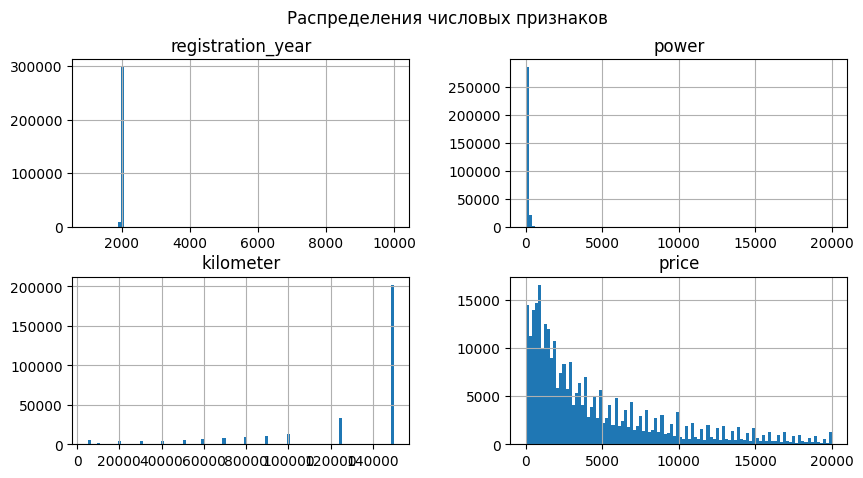

In [23]:
data[num_cols].hist(bins=100, figsize=(10, 5))
plt.suptitle('Распределения числовых признаков');

По гистограмам видно что есть аномальные значения в годе регистрации (около 1000), мощности, а также надо проверить значения около 0 в цене.

In [24]:
print('Количество нулей в "price":', data.loc[data['price'] == 0, 'price'].count())
print('Процент нулей:', data.loc[data['price'] == 0, 'price'].count()*100/len(data))

Количество нулей в "price": 8510
Процент нулей: 2.774553658759243


Поскольку price - целевой признак, придется удалить сроки с нулевыми значениями. Однако и другие значения близкие к нулю выглядят сомнительно, проверим их.

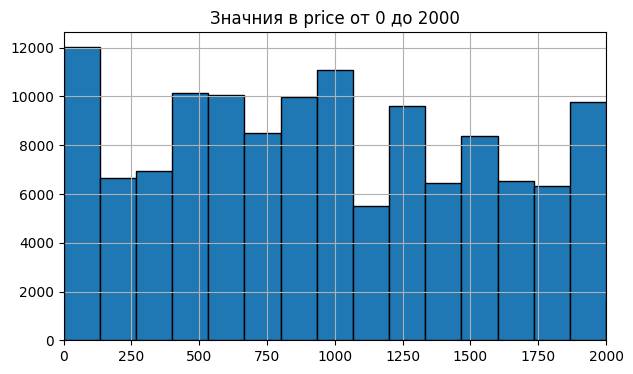

In [25]:
data['price'].hist(bins=150, figsize=(7, 4), edgecolor='black')
plt.xlim(0, 2000)
plt.title('Значния в price от 0 до 2000');

Отбросим значения ниже 100 евро.

In [26]:
data = data.loc[data['price'] > 100]

In [27]:
data.shape[0]

295139

In [28]:
data.loc[data['power'] == 0, 'power'].count()
print('Процент нулей в колонке power:', 
      data.loc[data['power'] == 0, 'power'].count()*100/len(data))

Процент нулей в колонке power: 10.285662010103714


Выявлены нулевые значения в колонке power. Данных больше 10%. удалять их нельзя, заменим медианными значениями по моделям. После того как уберем аномальные значения.

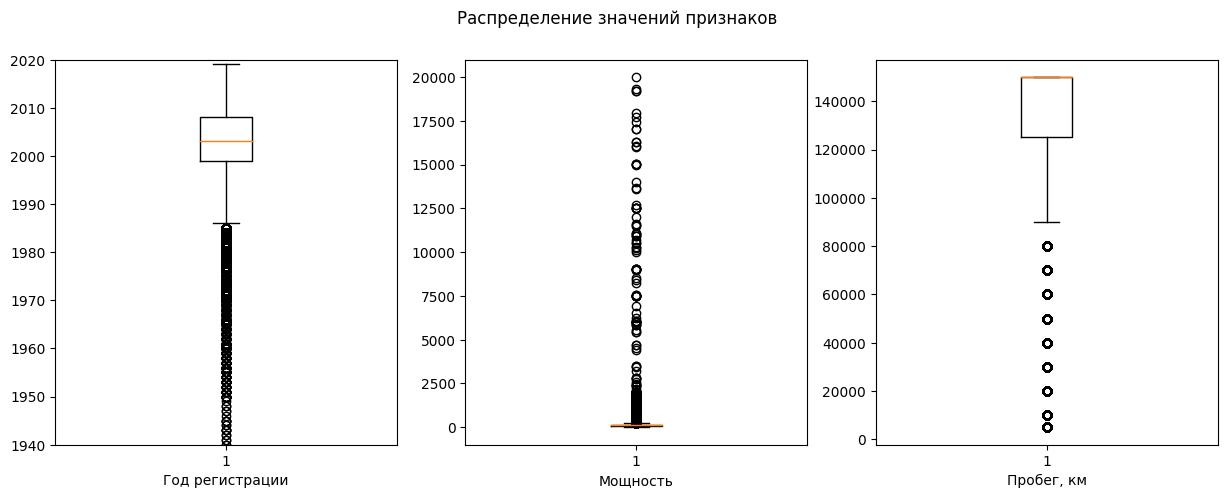

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5)) 

ax1.boxplot(data['registration_year'])
ax2.boxplot(data['power'])
ax3.boxplot(data['kilometer'])

fig.suptitle("Распределение значений признаков")
ax1.set_xlabel('Год регистрации')
ax1.set_ylim(1940,2020)
ax2.set_xlabel('Мощность')
ax3.set_xlabel('Пробег, км');

In [30]:
#sorted(data['registration_year'].unique())
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1965, 1970, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 1000, 1941,
       9999, 1500, 2200, 1962, 1929, 1957, 1940, 3000, 2066, 1949, 2019,
       1937, 1951, 1959, 1953, 1954, 9000, 2900, 6000, 5900, 5911, 1400,
       5000, 1950, 4000, 1948, 1952, 8500, 1932, 3700, 4800, 1942, 1935,
       1933, 1936, 1923, 2290, 1930, 1001, 1234, 9450, 1944, 7000, 2500,
       1943, 1938, 1934, 1928, 5555, 1800, 1039, 1300, 2800, 1931, 4500,
       1602, 7800, 1947, 1927, 7100, 8200, 1946, 1600], dtype=int64)

Много аномальных значений в registration_year и power. Год регистрации ограничим значениями от 1960 до 2016. Более поздние модели можно считать уже раритетом. В случае с мощностью возмножно были указаны не л.с. а ваты, этим можно объяснить очень большие значения. Самая мощная машина имеет двигатель с около 2000 л.с., но это исключение, будем считать аномальными значения выше 700 л.с. Отбросим данные превышающие это значение. Аномальные значения пробега оставим, тк они выглядят правдоподобно и значение пробега сильно влияют на цену автомобиля.

In [31]:
data = data.loc[(data['registration_year'] <= 2016) & (data['registration_year'] >= 1960)]
data = data.loc[(data['power'] <= 700)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281944 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              281944 non-null  int64 
 1   vehicle_type       281944 non-null  object
 2   registration_year  281944 non-null  int64 
 3   gearbox            281944 non-null  object
 4   power              281944 non-null  int64 
 5   model              281944 non-null  object
 6   kilometer          281944 non-null  int64 
 7   fuel_type          281944 non-null  object
 8   brand              281944 non-null  object
 9   repaired           281944 non-null  object
dtypes: int64(4), object(6)
memory usage: 23.7+ MB


In [32]:
data.loc[data['power'] == 0, 'power'].count()

27113

27 тысяч нулевых значений признаков power, заменим их медианными значениями внутри категории модель.

In [33]:
for p in data['model'].unique():
    data.loc[(data['model'] == p) & (data['power'] == 0),'power'] = \
    data.loc[(data['model'] == p), 'power'].median()

In [34]:
data = data.loc[(data['power'] > 20)]
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281577 entries, 0 to 281576
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   price              281577 non-null  int64  
 1   vehicle_type       281577 non-null  object 
 2   registration_year  281577 non-null  int64  
 3   gearbox            281577 non-null  object 
 4   power              281577 non-null  float64
 5   model              281577 non-null  object 
 6   kilometer          281577 non-null  int64  
 7   fuel_type          281577 non-null  object 
 8   brand              281577 non-null  object 
 9   repaired           281577 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 21.5+ MB


Проверим взаимосвязи признаков и корреляцию.

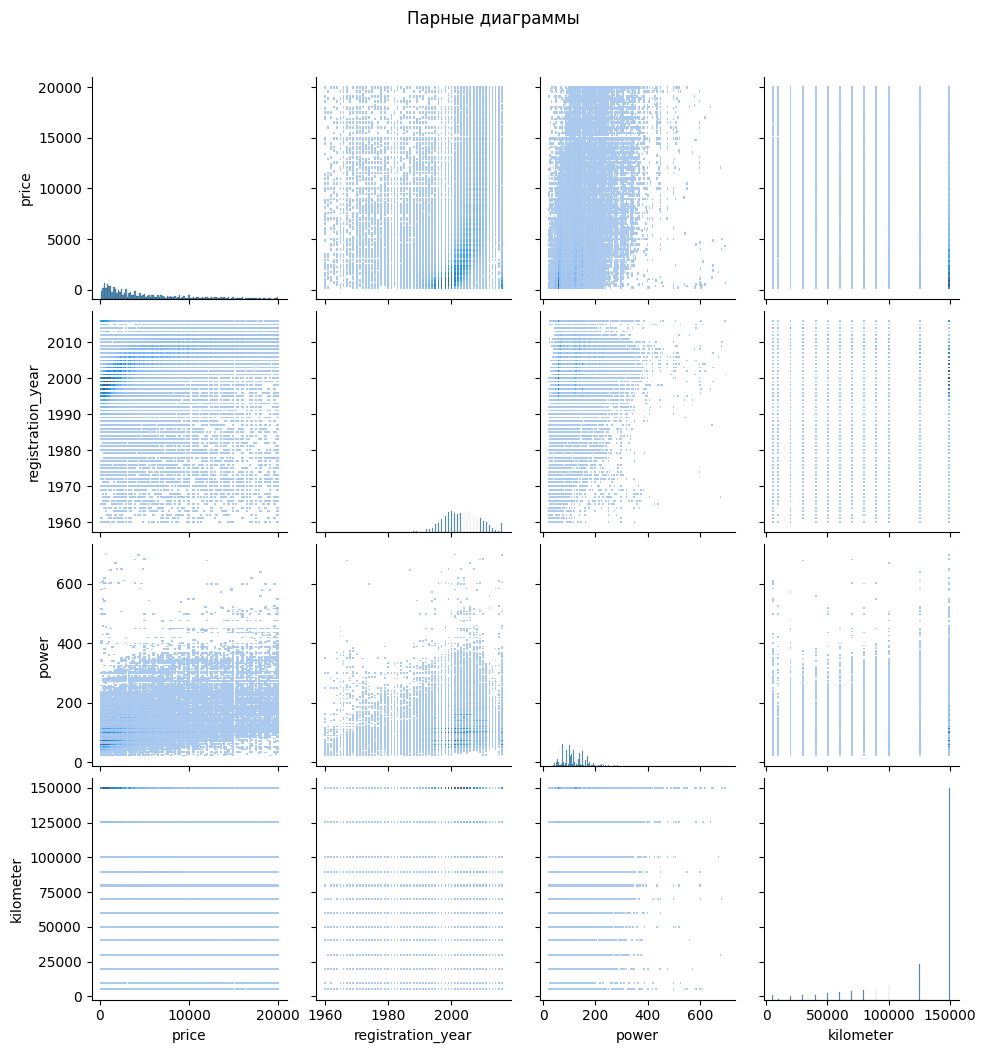

In [35]:
sns.pairplot(data, kind='hist').fig.suptitle('Парные диаграммы', y=1.05)
plt.show()

Видно связь мощности  и годов выпуска, со временем мощность выпускаемых автомобилей становится выше.А также  видно что много автомобилей с высоким значение пробега и низкой ценой. Для изучения взаимосвязей категориальных и числовых признаков используем корреляцию  phik.

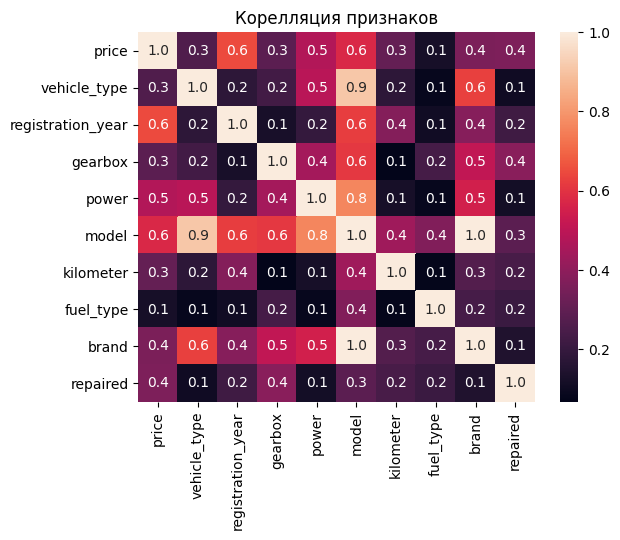

In [36]:
matrix = data.phik_matrix(interval_cols=num_cols)
sns.heatmap(matrix, annot=True, fmt=".1f")
plt.title('Корелляция признаков');

На тепловой карте корелляции видна сильная связь между парами признаков модель-мощность/тип кузова. Ожидаемая прямая связь между моделью и брендом. Умеренная связь между целевым признаком и годом регистрации и моделью. Мощность не так сильно влияет на цену, как ожидалось.  

*Итог: Было выявлено занчительное количество пропусков: 20% в колонке Repaired, 10,5% в типе кузова, 9.3% в типе топлива, по 5,6% в типе коробки передач и модели автомобиля.  Пропуски в vehicle_type заполнили популярными значениями из других строк с той же моделью. Пропуски в 'repaired', 'fuel_type', 'model' и 'gearbox' заполнены значениями 'unknown'. Было удалено 4 дубликата, 2392 строки с попущеннымим значениями всех категориальных признаков и  8510 строк с нулями в целевом признаке price.Значения типов топлива petrol и gasoline oбъединили в одно значение petrol. Аномальные значения в колонках 'registration_year' и 'power' были удалены. Аномальных и неинофрмативных данных было удалено примерно 3.6 % от первоналального размера датафрейма.*

*Были удалены неинформативные колонки 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen','DateCrawled', 'RegistrationMonth'. После этого было удалено еще 45883 образовавшихся дубликатов. Названия оставшихся колонок были приведены к змеиному регистру. Выявлено более 27 тысяч строк с нулями в колонке 'power', нули были заменены на медианные значения внутри каждой модели. 
Всего было удалено 71427 строк, из них 45887 дубликатов.*

## Обучение моделей

Разделим данные на тренировочную и тестовую выборки. Обучим модели DesicionTreeRegressor и RandomForestRegressor а также модели с градентным бустингом CatBoostRegressor и LGBMRegressor. Поскольку в данных много категориальных признаков  с большим количеством разных значений используем порядковое кодирование для этих колонок. Для колонок с численными данными применим масштабирование. Признак kilometer отнесем к категориальным, так как значения кратны 5000 и их не очень много. Используем инструмент pipeline.

In [37]:
features = data.drop(['price'], axis=1)
target = data['price']

In [38]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.25,
                                                                            random_state=125)

In [39]:
print(features_train.shape, features_test.shape)
print(target_train.shape, target_test.shape)

(211182, 9) (70395, 9)
(211182,) (70395,)


In [40]:
cat_columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired', 'kilometer']
num_columns = ['registration_year', 'power']

In [41]:
column_transformer = make_column_transformer((StandardScaler(), num_columns),
                                             (OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1), cat_columns),
                                              remainder='passthrough')
column_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('standardscaler', StandardScaler(),
                                 ['registration_year', 'power']),
                                ('ordinalencoder',
                                 OrdinalEncoder(handle_unknown='use_encoded_value',
                                                unknown_value=-1),
                                 ['vehicle_type', 'gearbox', 'model',
                                  'fuel_type', 'brand', 'repaired',
                                  'kilometer'])])

### Модель  DesicionTreeRegressor

Cоздадим функцию для расчета RMSE и использования в GridSearchCV. Далее ячейки с GridSearchCV закомментированы, тк подбор параметров происходит достаточно долго.

In [42]:
dtr = DecisionTreeRegressor(random_state=125)
pipeline_dtr = make_pipeline(column_transformer, dtr) 
pipeline_dtr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'power']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'kilometer'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random

In [43]:
param_grid_dtr = {'decisiontreeregressor__max_depth': range (2,11,1),
                  'decisiontreeregressor__min_samples_leaf': range (1,12,1)}

In [44]:
%%time

search_dtr = GridSearchCV(pipeline_dtr, param_grid_dtr, cv=4,
                          scoring = 'neg_root_mean_squared_error')
search_dtr.fit(features_train, target_train)

print('Лучшие гиперпараметры:', search_dtr.best_params_)
print('Значение RMSE:', -(search_dtr.best_score_))

Лучшие гиперпараметры: {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 11}
Значение RMSE: 2017.1034104508321
CPU times: total: 3min 13s
Wall time: 3min 13s


Лучшие гиперпараметры: {'decisiontreeregressor__max_depth': 10, 'decisiontreeregressor__min_samples_leaf': 11}
Значение RMSE: 2017.1034104508321
CPU times: total: 3min 3s
Wall time: 3min 9s

In [45]:
#время обучения
%%time
best_dtr = search_dtr.best_estimator_
best_dtr.fit(features_train, target_train)

CPU times: total: 750 ms
Wall time: 749 ms


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'power']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'kilometer'])])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(max_de

In [46]:
%%time
predict_dtr = search_dtr.best_estimator_.predict(features_test)

CPU times: total: 93.8 ms
Wall time: 97.7 ms


### Модель RandomForestRegressor

In [47]:
model_rfr = RandomForestRegressor(random_state=125)
pipeline_rfr = make_pipeline(column_transformer, model_rfr) 
pipeline_rfr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'power']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'kilometer'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random

In [48]:
param_grid_rfr = {'randomforestregressor__max_depth': range (1,10,1),
                  'randomforestregressor__min_samples_leaf': range (1,5,1),
                  'randomforestregressor__n_estimators': range(10, 70, 10)}

In [49]:
%%time

search_rfr = GridSearchCV(pipeline_rfr, param_grid_rfr, cv=5, 
                          scoring = 'neg_root_mean_squared_error')
search_rfr.fit(features_train, target_train)

print('Лучшие гиперпараметры:', search_rfr.best_params_)
print('Значение RMSE:', -(search_rfr.best_score_))

Лучшие гиперпараметры: {'randomforestregressor__max_depth': 9, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__n_estimators': 60}
Значение RMSE: 1987.5580254471668
CPU times: total: 1h 15min 20s
Wall time: 1h 15min 31s


Лучшие гиперпараметры: {'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 60}
Значение RMSE: 1989.9753255336545
CPU times: user 1h 18min 38s, sys: 11.2 s, total: 1h 18min 49s
Wall time: 1h 18min 54s

In [50]:
%%time
best_rfr = search_rfr.best_estimator_
best_rfr.fit(features_train, target_train)

CPU times: total: 15.2 s
Wall time: 15.3 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'power']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'kilometer'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_de

In [51]:
%%time
predict_rfr = search_rfr.best_estimator_.predict(features_test)

CPU times: total: 406 ms
Wall time: 399 ms


### Модель CatBoostRegressor

По умолчанию CatBoostRegressor() использует loss_function='RMSE'. 

In [52]:
model_сbr = CatBoostRegressor(verbose=50, iterations = 300, random_state=125)

pipeline_сbr = make_pipeline(column_transformer, model_сbr) 
pipeline_сbr

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'power']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'kilometer'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor

In [53]:
grid_cbr = {'catboostregressor__learning_rate': [0.05, 0.1, 0.3],
            'catboostregressor__depth': range(3,9),
            'catboostregressor__min_data_in_leaf': range(3,7)}

In [54]:
%%time

search_cbr = GridSearchCV(pipeline_сbr, grid_cbr, cv=5, 
                          scoring = 'neg_root_mean_squared_error')
search_cbr.fit(features_train, target_train)
print('Лучшие гиперпараметры:', search_cbr.best_params_)
print('Значение RMSE:', -(search_cbr.best_score_))

0:	learn: 4480.4769621	total: 210ms	remaining: 1m 2s
50:	learn: 2473.6054865	total: 594ms	remaining: 2.9s
100:	learn: 2197.7353913	total: 953ms	remaining: 1.88s
150:	learn: 2092.5453409	total: 1.31s	remaining: 1.29s
200:	learn: 2026.6181356	total: 1.68s	remaining: 827ms
250:	learn: 1981.8513147	total: 2.04s	remaining: 399ms
299:	learn: 1947.8270604	total: 2.4s	remaining: 0us
0:	learn: 4475.9129750	total: 14.4ms	remaining: 4.3s
50:	learn: 2484.2123424	total: 388ms	remaining: 1.9s
100:	learn: 2204.6732766	total: 746ms	remaining: 1.47s
150:	learn: 2098.6443177	total: 1.09s	remaining: 1.08s
200:	learn: 2031.7010525	total: 1.45s	remaining: 712ms
250:	learn: 1985.0805940	total: 1.81s	remaining: 353ms
299:	learn: 1952.9394967	total: 2.16s	remaining: 0us
0:	learn: 4481.1070164	total: 9.29ms	remaining: 2.78s
50:	learn: 2478.7391992	total: 391ms	remaining: 1.91s
100:	learn: 2199.8978039	total: 815ms	remaining: 1.6s
150:	learn: 2091.2744430	total: 1.2s	remaining: 1.19s
200:	learn: 2025.5016591	to

250:	learn: 1875.5223140	total: 1.87s	remaining: 364ms
299:	learn: 1853.6121608	total: 2.27s	remaining: 0us
0:	learn: 4360.5115540	total: 10.3ms	remaining: 3.08s
50:	learn: 2191.6556155	total: 473ms	remaining: 2.31s
100:	learn: 2020.0978790	total: 881ms	remaining: 1.74s
150:	learn: 1942.0500857	total: 1.25s	remaining: 1.23s
200:	learn: 1899.6012326	total: 1.61s	remaining: 794ms
250:	learn: 1869.6549577	total: 1.98s	remaining: 387ms
299:	learn: 1846.7742286	total: 2.35s	remaining: 0us
0:	learn: 4353.4119437	total: 15.3ms	remaining: 4.56s
50:	learn: 2189.3208012	total: 399ms	remaining: 1.95s
100:	learn: 2021.5410473	total: 782ms	remaining: 1.54s
150:	learn: 1946.3374431	total: 1.16s	remaining: 1.14s
200:	learn: 1900.1450014	total: 1.53s	remaining: 756ms
250:	learn: 1868.6562404	total: 1.92s	remaining: 375ms
299:	learn: 1846.9264834	total: 2.27s	remaining: 0us
0:	learn: 4354.1387979	total: 8.51ms	remaining: 2.54s
50:	learn: 2189.6800787	total: 399ms	remaining: 1.95s
100:	learn: 2021.90025

100:	learn: 1860.8365531	total: 782ms	remaining: 1.54s
150:	learn: 1815.9867132	total: 1.15s	remaining: 1.13s
200:	learn: 1787.8451795	total: 1.51s	remaining: 743ms
250:	learn: 1763.9280944	total: 1.87s	remaining: 366ms
299:	learn: 1746.2062008	total: 2.23s	remaining: 0us
0:	learn: 3910.3737800	total: 8.64ms	remaining: 2.58s
50:	learn: 1956.3467577	total: 369ms	remaining: 1.8s
100:	learn: 1854.3865623	total: 728ms	remaining: 1.43s
150:	learn: 1809.8909406	total: 1.08s	remaining: 1.07s
200:	learn: 1781.6855480	total: 1.44s	remaining: 708ms
250:	learn: 1759.3082150	total: 1.79s	remaining: 350ms
299:	learn: 1742.6195428	total: 2.15s	remaining: 0us
0:	learn: 3916.1078131	total: 9.38ms	remaining: 2.8s
50:	learn: 1951.5883347	total: 402ms	remaining: 1.96s
100:	learn: 1858.0253985	total: 779ms	remaining: 1.53s
150:	learn: 1813.9149777	total: 1.17s	remaining: 1.16s
200:	learn: 1783.2916477	total: 1.56s	remaining: 770ms
250:	learn: 1763.2995252	total: 1.93s	remaining: 376ms
299:	learn: 1745.212

299:	learn: 1861.2668672	total: 2.49s	remaining: 0us
0:	learn: 4472.1412738	total: 10.9ms	remaining: 3.26s
50:	learn: 2347.8496265	total: 438ms	remaining: 2.14s
100:	learn: 2099.8031152	total: 839ms	remaining: 1.65s
150:	learn: 1997.0318866	total: 1.24s	remaining: 1.22s
200:	learn: 1938.4790274	total: 1.66s	remaining: 816ms
250:	learn: 1897.8710323	total: 2.08s	remaining: 406ms
299:	learn: 1871.2491673	total: 2.49s	remaining: 0us
0:	learn: 4467.6955351	total: 9.75ms	remaining: 2.92s
50:	learn: 2349.3038453	total: 436ms	remaining: 2.13s
100:	learn: 2105.2706062	total: 836ms	remaining: 1.65s
150:	learn: 2003.9770453	total: 1.24s	remaining: 1.22s
200:	learn: 1945.2548966	total: 1.63s	remaining: 805ms
250:	learn: 1904.7739928	total: 2.03s	remaining: 397ms
299:	learn: 1876.5247592	total: 2.46s	remaining: 0us
0:	learn: 4472.7588552	total: 9.92ms	remaining: 2.97s
50:	learn: 2342.1515920	total: 430ms	remaining: 2.1s
100:	learn: 2097.8699768	total: 842ms	remaining: 1.66s
150:	learn: 1997.095798

150:	learn: 1874.4123077	total: 1.36s	remaining: 1.34s
200:	learn: 1834.7476997	total: 1.78s	remaining: 875ms
250:	learn: 1809.2871539	total: 2.19s	remaining: 428ms
299:	learn: 1789.6181286	total: 2.62s	remaining: 0us
0:	learn: 4343.7764215	total: 12.2ms	remaining: 3.63s
50:	learn: 2087.9214620	total: 452ms	remaining: 2.21s
100:	learn: 1931.2844454	total: 849ms	remaining: 1.67s
150:	learn: 1862.5509880	total: 1.26s	remaining: 1.24s
200:	learn: 1824.0863927	total: 1.68s	remaining: 828ms
250:	learn: 1796.9670105	total: 2.09s	remaining: 408ms
299:	learn: 1778.1513810	total: 2.5s	remaining: 0us
0:	learn: 4336.6134040	total: 14.1ms	remaining: 4.21s
50:	learn: 2089.7127068	total: 432ms	remaining: 2.11s
100:	learn: 1935.8484836	total: 840ms	remaining: 1.66s
150:	learn: 1867.8282379	total: 1.25s	remaining: 1.24s
200:	learn: 1828.2154121	total: 1.67s	remaining: 824ms
250:	learn: 1802.5834782	total: 2.09s	remaining: 408ms
299:	learn: 1783.5783932	total: 2.5s	remaining: 0us
0:	learn: 4337.1822846

0:	learn: 3859.9259167	total: 10.2ms	remaining: 3.05s
50:	learn: 1877.2603623	total: 433ms	remaining: 2.11s
100:	learn: 1795.1393597	total: 838ms	remaining: 1.65s
150:	learn: 1758.7335396	total: 1.24s	remaining: 1.23s
200:	learn: 1729.5047715	total: 1.65s	remaining: 815ms
250:	learn: 1705.8707177	total: 2.07s	remaining: 404ms
299:	learn: 1688.0542601	total: 2.47s	remaining: 0us
0:	learn: 3859.4545180	total: 10.5ms	remaining: 3.14s
50:	learn: 1872.3749453	total: 427ms	remaining: 2.09s
100:	learn: 1789.1320351	total: 851ms	remaining: 1.68s
150:	learn: 1750.2818715	total: 1.29s	remaining: 1.27s
200:	learn: 1721.2625230	total: 1.7s	remaining: 837ms
250:	learn: 1699.7055643	total: 2.13s	remaining: 416ms
299:	learn: 1683.7468058	total: 2.54s	remaining: 0us
0:	learn: 3865.9394200	total: 9.75ms	remaining: 2.91s
50:	learn: 1875.3497042	total: 425ms	remaining: 2.08s
100:	learn: 1792.8953434	total: 836ms	remaining: 1.65s
150:	learn: 1751.2377520	total: 1.25s	remaining: 1.23s
200:	learn: 1723.3526

200:	learn: 1872.7281577	total: 1.91s	remaining: 939ms
250:	learn: 1836.6301309	total: 2.38s	remaining: 464ms
299:	learn: 1811.0753869	total: 2.83s	remaining: 0us
0:	learn: 4465.4956109	total: 17.1ms	remaining: 5.11s
50:	learn: 2256.1462369	total: 500ms	remaining: 2.44s
100:	learn: 2020.8579880	total: 969ms	remaining: 1.91s
150:	learn: 1928.6808363	total: 1.42s	remaining: 1.4s
200:	learn: 1879.5493944	total: 1.87s	remaining: 922ms
250:	learn: 1844.7480421	total: 2.33s	remaining: 454ms
299:	learn: 1818.8759618	total: 2.79s	remaining: 0us
0:	learn: 4460.4678477	total: 24.8ms	remaining: 7.41s
50:	learn: 2261.3340795	total: 512ms	remaining: 2.5s
100:	learn: 2028.2358746	total: 965ms	remaining: 1.9s
150:	learn: 1934.3756628	total: 1.43s	remaining: 1.41s
200:	learn: 1882.5408734	total: 1.9s	remaining: 935ms
250:	learn: 1848.9691429	total: 2.38s	remaining: 465ms
299:	learn: 1823.4082725	total: 2.83s	remaining: 0us
0:	learn: 4465.5471390	total: 17ms	remaining: 5.07s
50:	learn: 2255.9466384	tot

50:	learn: 2017.5774833	total: 479ms	remaining: 2.34s
100:	learn: 1882.0259861	total: 922ms	remaining: 1.81s
150:	learn: 1819.8900588	total: 1.38s	remaining: 1.36s
200:	learn: 1784.3133034	total: 1.84s	remaining: 907ms
250:	learn: 1759.1920598	total: 2.31s	remaining: 450ms
299:	learn: 1741.6535561	total: 2.76s	remaining: 0us
0:	learn: 4329.2906878	total: 11ms	remaining: 3.28s
50:	learn: 2016.1827737	total: 481ms	remaining: 2.35s
100:	learn: 1875.2590243	total: 1.03s	remaining: 2.02s
150:	learn: 1814.7770325	total: 1.6s	remaining: 1.58s
200:	learn: 1777.9404432	total: 2.17s	remaining: 1.07s
250:	learn: 1754.1673549	total: 2.74s	remaining: 535ms
299:	learn: 1735.7335227	total: 3.29s	remaining: 0us
0:	learn: 4321.8941284	total: 12.1ms	remaining: 3.61s
50:	learn: 2012.4708771	total: 476ms	remaining: 2.32s
100:	learn: 1877.9344857	total: 922ms	remaining: 1.82s
150:	learn: 1816.8863980	total: 1.37s	remaining: 1.35s
200:	learn: 1779.2646771	total: 1.82s	remaining: 896ms
250:	learn: 1754.48164

250:	learn: 1650.4928260	total: 2.29s	remaining: 448ms
299:	learn: 1632.3856591	total: 2.73s	remaining: 0us
0:	learn: 3815.3223971	total: 16.2ms	remaining: 4.84s
50:	learn: 1829.9192078	total: 489ms	remaining: 2.38s
100:	learn: 1748.5186684	total: 958ms	remaining: 1.89s
150:	learn: 1704.3636742	total: 1.41s	remaining: 1.4s
200:	learn: 1673.6222569	total: 1.94s	remaining: 958ms
250:	learn: 1651.3644388	total: 2.39s	remaining: 467ms
299:	learn: 1632.3045930	total: 2.84s	remaining: 0us
0:	learn: 3815.0862752	total: 18.7ms	remaining: 5.59s
50:	learn: 1817.7206566	total: 480ms	remaining: 2.34s
100:	learn: 1743.7821098	total: 957ms	remaining: 1.89s
150:	learn: 1703.0506560	total: 1.43s	remaining: 1.41s
200:	learn: 1675.3295218	total: 1.89s	remaining: 929ms
250:	learn: 1650.9047862	total: 2.37s	remaining: 462ms
299:	learn: 1631.6360909	total: 2.83s	remaining: 0us
0:	learn: 3825.5042382	total: 11.1ms	remaining: 3.3s
50:	learn: 1829.9494342	total: 480ms	remaining: 2.35s
100:	learn: 1747.3701285

150:	learn: 1873.8734349	total: 1.6s	remaining: 1.58s
200:	learn: 1825.3690181	total: 2.16s	remaining: 1.06s
250:	learn: 1795.6610119	total: 2.72s	remaining: 532ms
299:	learn: 1772.2305334	total: 3.26s	remaining: 0us
0:	learn: 4459.5173943	total: 17.7ms	remaining: 5.28s
50:	learn: 2189.3535556	total: 548ms	remaining: 2.67s
100:	learn: 1963.1104938	total: 1.11s	remaining: 2.19s
150:	learn: 1878.1244131	total: 1.63s	remaining: 1.61s
200:	learn: 1831.1957007	total: 2.17s	remaining: 1.07s
250:	learn: 1799.9924721	total: 2.71s	remaining: 530ms
299:	learn: 1776.1563321	total: 3.23s	remaining: 0us
0:	learn: 4454.3052827	total: 12.8ms	remaining: 3.82s
50:	learn: 2193.0869433	total: 561ms	remaining: 2.74s
100:	learn: 1966.0804905	total: 1.08s	remaining: 2.12s
150:	learn: 1882.9370526	total: 1.6s	remaining: 1.58s
200:	learn: 1835.9328519	total: 2.13s	remaining: 1.05s
250:	learn: 1804.9253541	total: 2.65s	remaining: 517ms
299:	learn: 1781.2164448	total: 3.18s	remaining: 0us
0:	learn: 4459.5263054

0:	learn: 4312.3928190	total: 12.3ms	remaining: 3.67s
50:	learn: 1965.5238168	total: 526ms	remaining: 2.57s
100:	learn: 1835.7736216	total: 1.04s	remaining: 2.04s
150:	learn: 1780.1386557	total: 1.56s	remaining: 1.54s
200:	learn: 1746.5761525	total: 2.09s	remaining: 1.03s
250:	learn: 1720.5709202	total: 2.61s	remaining: 509ms
299:	learn: 1702.5930520	total: 3.15s	remaining: 0us
0:	learn: 4317.1763274	total: 13.1ms	remaining: 3.92s
50:	learn: 1953.7279861	total: 535ms	remaining: 2.61s
100:	learn: 1824.8896602	total: 1.07s	remaining: 2.11s
150:	learn: 1768.6243106	total: 1.59s	remaining: 1.57s
200:	learn: 1735.0324888	total: 2.12s	remaining: 1.04s
250:	learn: 1712.1236760	total: 2.63s	remaining: 514ms
299:	learn: 1691.9056390	total: 3.15s	remaining: 0us
0:	learn: 4309.8013185	total: 12.4ms	remaining: 3.7s
50:	learn: 1954.6910680	total: 533ms	remaining: 2.6s
100:	learn: 1832.5685907	total: 1.06s	remaining: 2.09s
150:	learn: 1776.5144752	total: 1.59s	remaining: 1.57s
200:	learn: 1742.86169

250:	learn: 1604.1722817	total: 2.59s	remaining: 505ms
299:	learn: 1584.6887524	total: 3.08s	remaining: 0us
0:	learn: 3778.3783621	total: 12.1ms	remaining: 3.61s
50:	learn: 1783.4465920	total: 532ms	remaining: 2.6s
100:	learn: 1703.2071456	total: 1.07s	remaining: 2.11s
150:	learn: 1660.7836521	total: 1.6s	remaining: 1.58s
200:	learn: 1630.2146347	total: 2.13s	remaining: 1.05s
250:	learn: 1605.1481424	total: 2.65s	remaining: 517ms
299:	learn: 1585.3980410	total: 3.14s	remaining: 0us
0:	learn: 3776.7999635	total: 22.6ms	remaining: 6.77s
50:	learn: 1776.9934777	total: 560ms	remaining: 2.73s
100:	learn: 1699.4148430	total: 1.12s	remaining: 2.21s
150:	learn: 1656.4137633	total: 1.79s	remaining: 1.76s
200:	learn: 1626.1509547	total: 2.32s	remaining: 1.14s
250:	learn: 1602.2873912	total: 2.85s	remaining: 555ms
299:	learn: 1581.8028654	total: 3.36s	remaining: 0us
0:	learn: 4451.1009107	total: 13.4ms	remaining: 4s
50:	learn: 2128.4032707	total: 602ms	remaining: 2.94s
100:	learn: 1914.5969567	to

150:	learn: 1830.3181151	total: 1.74s	remaining: 1.71s
200:	learn: 1785.4997885	total: 2.32s	remaining: 1.14s
250:	learn: 1753.9678367	total: 2.92s	remaining: 571ms
299:	learn: 1732.0855452	total: 3.49s	remaining: 0us
0:	learn: 4301.2457919	total: 18.7ms	remaining: 5.6s
50:	learn: 1909.6805587	total: 602ms	remaining: 2.94s
100:	learn: 1795.1191247	total: 1.17s	remaining: 2.31s
150:	learn: 1739.0290252	total: 1.75s	remaining: 1.73s
200:	learn: 1705.7264141	total: 2.35s	remaining: 1.16s
250:	learn: 1680.2980274	total: 2.93s	remaining: 573ms
299:	learn: 1659.7894641	total: 3.52s	remaining: 0us
0:	learn: 4296.7852990	total: 13.9ms	remaining: 4.15s
50:	learn: 1913.7704307	total: 599ms	remaining: 2.93s
100:	learn: 1795.7889530	total: 1.17s	remaining: 2.31s
150:	learn: 1745.1914460	total: 1.74s	remaining: 1.72s
200:	learn: 1710.2403371	total: 2.33s	remaining: 1.15s
250:	learn: 1684.4047036	total: 2.9s	remaining: 566ms
299:	learn: 1664.5771882	total: 3.45s	remaining: 0us
0:	learn: 4300.3560664

0:	learn: 3732.4521773	total: 14.8ms	remaining: 4.41s
50:	learn: 1752.2799348	total: 596ms	remaining: 2.91s
100:	learn: 1669.2128553	total: 1.19s	remaining: 2.34s
150:	learn: 1622.6323054	total: 1.78s	remaining: 1.75s
200:	learn: 1588.7175514	total: 2.34s	remaining: 1.15s
250:	learn: 1561.0813155	total: 2.92s	remaining: 571ms
299:	learn: 1538.5706252	total: 3.52s	remaining: 0us
0:	learn: 3731.7532487	total: 14.5ms	remaining: 4.32s
50:	learn: 1743.2911524	total: 625ms	remaining: 3.05s
100:	learn: 1663.1729620	total: 1.21s	remaining: 2.38s
150:	learn: 1616.6225406	total: 1.79s	remaining: 1.77s
200:	learn: 1582.1940815	total: 2.44s	remaining: 1.2s
250:	learn: 1554.7200072	total: 3.04s	remaining: 593ms
299:	learn: 1532.5510263	total: 3.63s	remaining: 0us
0:	learn: 3725.5359017	total: 19ms	remaining: 5.69s
50:	learn: 1751.2249241	total: 603ms	remaining: 2.94s
100:	learn: 1665.6338945	total: 1.19s	remaining: 2.33s
150:	learn: 1616.1284415	total: 1.76s	remaining: 1.74s
200:	learn: 1583.485915

200:	learn: 1752.9422610	total: 3.34s	remaining: 1.65s
250:	learn: 1722.8465864	total: 4.04s	remaining: 788ms
299:	learn: 1700.0415720	total: 4.69s	remaining: 0us
0:	learn: 4438.5692096	total: 15.5ms	remaining: 4.65s
50:	learn: 2079.4272019	total: 732ms	remaining: 3.57s
100:	learn: 1871.6693003	total: 1.4s	remaining: 2.76s
150:	learn: 1799.1640290	total: 2.06s	remaining: 2.03s
200:	learn: 1756.7457845	total: 2.72s	remaining: 1.34s
250:	learn: 1726.0950748	total: 3.4s	remaining: 663ms
299:	learn: 1703.6744121	total: 4.05s	remaining: 0us
0:	learn: 4439.4591801	total: 18.7ms	remaining: 5.6s
50:	learn: 2075.2382587	total: 713ms	remaining: 3.48s
100:	learn: 1867.1315130	total: 1.38s	remaining: 2.73s
150:	learn: 1794.4352159	total: 2.07s	remaining: 2.04s
200:	learn: 1751.6050393	total: 2.77s	remaining: 1.36s
250:	learn: 1721.9182261	total: 3.5s	remaining: 684ms
299:	learn: 1699.9345230	total: 4.16s	remaining: 0us
0:	learn: 4446.5683851	total: 15.5ms	remaining: 4.64s
50:	learn: 2075.7459437	t

50:	learn: 1862.7692440	total: 801ms	remaining: 3.91s
100:	learn: 1754.3624537	total: 1.51s	remaining: 2.98s
150:	learn: 1703.3274333	total: 2.19s	remaining: 2.16s
200:	learn: 1669.4218096	total: 2.86s	remaining: 1.41s
250:	learn: 1642.0745910	total: 3.55s	remaining: 692ms
299:	learn: 1620.7403294	total: 4.21s	remaining: 0us
0:	learn: 4292.0994299	total: 17.2ms	remaining: 5.14s
50:	learn: 1875.7683085	total: 837ms	remaining: 4.08s
100:	learn: 1761.6118530	total: 1.57s	remaining: 3.09s
150:	learn: 1706.7111244	total: 2.26s	remaining: 2.23s
200:	learn: 1671.1699832	total: 2.96s	remaining: 1.46s
250:	learn: 1644.2673352	total: 3.63s	remaining: 709ms
299:	learn: 1624.5340640	total: 4.3s	remaining: 0us
0:	learn: 4287.9181260	total: 17ms	remaining: 5.08s
50:	learn: 1876.1349577	total: 694ms	remaining: 3.39s
100:	learn: 1761.2343745	total: 1.36s	remaining: 2.67s
150:	learn: 1708.3215492	total: 2.02s	remaining: 2s
200:	learn: 1672.9792082	total: 2.68s	remaining: 1.32s
250:	learn: 1644.7952252	

299:	learn: 1489.1062878	total: 4.04s	remaining: 0us
0:	learn: 3704.9665952	total: 16.3ms	remaining: 4.89s
50:	learn: 1718.0160569	total: 690ms	remaining: 3.37s
100:	learn: 1633.9210698	total: 1.36s	remaining: 2.69s
150:	learn: 1581.4055378	total: 2.04s	remaining: 2.01s
200:	learn: 1544.1647891	total: 2.7s	remaining: 1.33s
250:	learn: 1514.5968647	total: 3.36s	remaining: 657ms
299:	learn: 1490.2598898	total: 4.03s	remaining: 0us
0:	learn: 3703.7107687	total: 18.1ms	remaining: 5.42s
50:	learn: 1710.7893678	total: 856ms	remaining: 4.18s
100:	learn: 1627.1450859	total: 1.69s	remaining: 3.32s
150:	learn: 1576.0799427	total: 2.52s	remaining: 2.48s
200:	learn: 1541.2907824	total: 3.3s	remaining: 1.63s
250:	learn: 1510.9812073	total: 3.96s	remaining: 774ms
299:	learn: 1487.1304305	total: 4.61s	remaining: 0us
0:	learn: 3697.3569539	total: 15.1ms	remaining: 4.51s
50:	learn: 1709.3792832	total: 675ms	remaining: 3.29s
100:	learn: 1624.3988431	total: 1.34s	remaining: 2.64s
150:	learn: 1574.7010543

Лучшие гиперпараметры: {'catboostregressor__depth': 8, 'catboostregressor__learning_rate': 0.3, 'catboostregressor__min_data_in_leaf': 3}
Значение RMSE: 1803.827452301338
CPU times: total: 2h 20min 46s
Wall time: 28min 5s

In [55]:
%%time
best_cbr = search_cbr.best_estimator_
best_cbr.fit(features_train, target_train)

0:	learn: 3701.5430080	total: 22.4ms	remaining: 6.7s
50:	learn: 1714.8490623	total: 821ms	remaining: 4.01s
100:	learn: 1633.9039362	total: 1.62s	remaining: 3.19s
150:	learn: 1585.9543276	total: 2.41s	remaining: 2.38s
200:	learn: 1554.4198212	total: 3.19s	remaining: 1.57s
250:	learn: 1527.1875192	total: 3.98s	remaining: 776ms
299:	learn: 1504.2878322	total: 4.75s	remaining: 0us
CPU times: total: 34.4 s
Wall time: 5.84 s


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['registration_year',
                                                   'power']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['vehicle_type', 'gearbox',
                                                   'model', 'fuel_type',
                                                   'brand', 'repaired',
                                                   'kilometer'])])),
                ('catboostregressor',
                 <catboost.core.CatBoostRegressor

In [56]:
%%time
predict_cbr = search_cbr.best_estimator_.predict(features_train)

CPU times: total: 812 ms
Wall time: 703 ms


### Модель LGBMRegressor

Лучшие гиперпараметры: {'max_depth': 9, 'min_data_in_leaf': 20, 'n_estimators': 150}
Значение RMSE: 1719.264754732308
CPU times: user 10min 39s, sys: 7.05 s, total: 10min 46s
Wall time: 10min 51s

In [ ]:
%%time
model_lgb =LGBMRegressor(objective='regression', max_depth=9, 
                         min_data_in_leaf=20, n_estimators=150,
                         random_state=125) 

model_lgb.fit(features_train, target_train)

In [ ]:
%%time
predict_lgb = model_lgb.predict(features_test)

Итог: Данные были подготовлены, категориальные признаки обработаны с помощью порядкового кодирования. 
Числовые параметры были промасштабированы. Обучено 4 модели регрессии. модели с градиентным бустингом CatBoostRegressor и LGBMRegressor показали лучший результат по качеству и времени обучения по сравнению с моделями Решающего дерева и Случайного леса. RMSE Случайного леса (1745) даже чуть лучше результата LGBMRegressor (1753), время обучения также лучше у Случайного леса, но стоит отметить, что очень много времени занимает подбор гиперпараметров для Случайного леса (больше часа).  

## Анализ моделей

In [57]:
data_list = {'model': ['desicion_tree', 'random_forest', 'catboost', 'lgbm'],
             'rmse_train': [2017, 1987, 1647, 1719.264],
             'train_time':[0.75, 15.3, 5.8, 8.42 ],
             'predict_time':[0.097, 0.4, 0.7, 0.674]}
             
results = pd.DataFrame(data=data_list)
results

,model,rmse_train,train_time,predict_time
0,desicion_tree,2017.000,0.75,0.097
1,random_forest,1987.000,15.30,0.400
2,catboost,1647.000,5.80,0.700
3,lgbm,1719.264,8.42,0.674


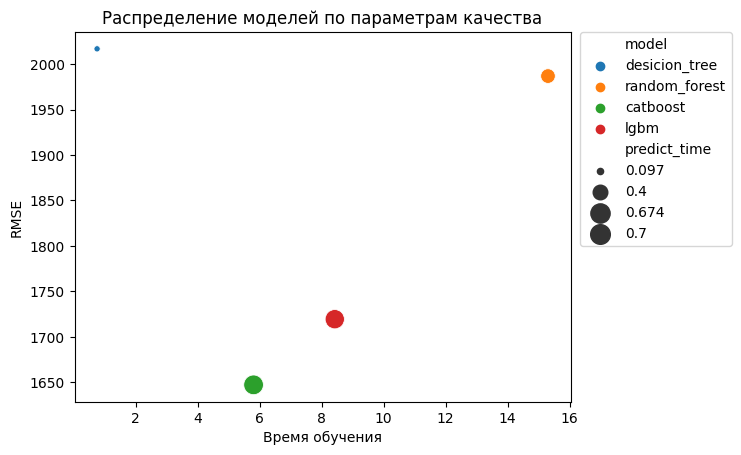

In [63]:
sns.scatterplot(data=results, x="train_time", y="rmse_train", hue="model", size="predict_time", sizes=(20, 200))
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Время обучения')
plt.ylabel('RMSE')
plt.title("Распределение моделей по параметрам качества");

Из графика следует, что лучшие модели находятся ближе к началу координат, где меньше и значение RMSE и время обучения моделей. Размеры точек указывают на время предсказания моделей. CatBoostRegressor имеет лучшие показатели по 2 параметрам из трех: RMSE и время обучения, время предсказания у LGBM лучше на десятые доли секунды, поэтому лучшей моделью можно считать CatBoostRegressor.

In [60]:
predict_cbr_test = search_cbr.best_estimator_.predict(features_test)

In [61]:
rmse_сbr = mean_squared_error(target_test, predict_cbr_test, squared=False)
print('RMSE Модели CatBoostRegressor на тестовой выборке:', rmse_сbr)

RMSE Модели CatBoostRegressor на тестовой выборке: 1653.7411423420176


Качество на тестовой выборке изменилось не значительно.

### Общий вывод

Было выявлено занчительное количество пропусков: 20% в колонке Repaired, 10,5% в типе кузова, 9.3% в типе топлива, по 5,6% в типе коробки передач и модели автомобиля. Пропуски в vehicle_type заполнили популярными значениями из других строк с той же моделью. Пропуски в 'repaired', 'fuel_type', 'model' и 'gearbox' заполнены значениями 'unknown'. Было удалено 4 дубликата, 2392 строки с попущеннымим значениями всех категориальных признаков и 8510 строк с нулями в целевом признаке price.Значения типов топлива petrol и gasoline oбъединили в одно значение petrol. Аномальные значения в колонках 'registration_year' и 'power' были удалены. Аномальных и неинофрмативных данных было удалено примерно 3.6 % от первоналального размера датафрейма.

Были удалены неинформативные колонки 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen','DateCrawled', 'RegistrationMonth'. После этого было удалено еще 45883 образовавшихся дубликатов. Названия оставшихся колонок были приведены к змеиному регистру. Выявлено более 30 000 строк с нулями в колонке 'power', нули были заменены на медианные значения для каждой модели. Всего было удалено 71427 строк, из них 45887 дубликатов.

Данные были подготовлены, категориальные признаки обработаны с помощью порядкового кодирования. Числовые параметры были промасштабированы. Обучено 4 модели регрессии: модели с градиентным бустингом CatBoostRegressor и LGBMRegressor в целом показали лучший результат по качеству и времени обучения по сравнению с моделями Решающего дерева и Случайного леса. 

Были проанализированы следующие параметры моделей: время на подбор гиперпараметров,  время обучения, время предсказания и RMSE обучения. Лучшими по значениям  RMSE, времени обучения и предсказания оказалась модель CatBoostRegressor. Качество на тестовой выборке изменилось не значительно.